In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 119kB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
     |████████████████████████████████| 3.8MB 24.4MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [2]:
'''
'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

tf.__version__

'2.0.0'

Read the input file and modify it to put in structred format

In [4]:
#Read the input file in google colab
from google.colab import files
uploaded = files.upload()
#cookies should not be blocked for this

Saving ts_test_43.csv to ts_test_43.csv


In [0]:
# Modify the CSV file to get proper data in sequence
text = open("ts_test_43.csv", "r")
text = ''.join([i for i in text]) \
    .replace(",", ".")\
    .replace(";",",")
x = open("input.csv","w")
x.writelines(text)
x.close()

In [6]:
# put the data in dataframe
df = pd.read_csv('input.csv')
df.head()

,Index,Val_1,Val_2,Val_3
0,1,26.950,10.771,22.770
1,2,46.662,10.195,22.660
2,3,30.470,12.611,13.530
3,4,24.794,14.682,18.249
4,5,35.849,14.277,23.727


In [7]:
df.dtypes

Index      int64
Val_1    float64
Val_2    float64
Val_3    float64
dtype: object

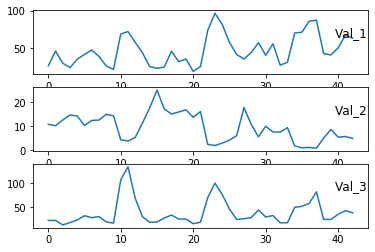

In [8]:
#visualizing Val_1,Val_2, Val_3
values = df.values
# specify columns to plot
groups = [1, 2, 3]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [9]:
#devide the data into training and validation data
df1 = df.drop(['Index'], axis=1)
dataset = df1.to_numpy()
dataset_train = dataset[:int(0.8*(len(dataset)))]
dataset_valid = dataset[int(0.8*(len(dataset))):]
print(dataset.shape,dataset_train.shape, dataset_valid.shape)

(43, 3) (34, 3) (9, 3)


In [0]:
#split the multivariate sequence into chunk of samples
def split_mult_seq(seq, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(seq)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check whether reached the boundary of the dataset
		if out_end_ix > len(seq):
			break
		# get all the input and output parts of the pattern
		seq_x, seq_y = seq[i:end_ix, :], seq[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# define lstm encoder and decoder model for multivariate sequence data
def multivariate_lstm(n_steps_in, n_features, n_steps_out):
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  return model

Predicting the sequnce with training data and validating the output

In [12]:
# choose the number of time steps for input and output time step
n_steps_out_train = len(dataset_valid)
n_steps_in_train = n_steps_out_train + 3
# covert train data to input or output array
X_train, y_train = split_mult_seq(dataset_train, n_steps_in_train, n_steps_out_train)
print(X_train.shape, y_train.shape)
# number of features
n_features_train = X_train.shape[2]

(14, 12, 3) (14, 9, 3)


In [0]:
#split the seqence and create the LSTM model
model1 = multivariate_lstm(n_steps_in_train, n_features_train, n_steps_out_train)
model1.compile(optimizer='adam', loss='mape',  metrics = ['accuracy'] )

In [0]:
# fit the model
hist = model1.fit(X_train, y_train, epochs=20, verbose=0, validation_split=0.2)

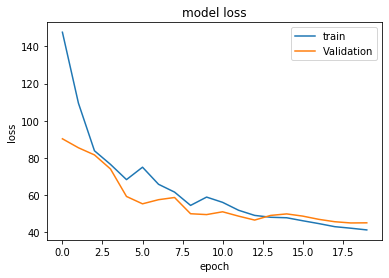

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()

In [35]:
# create the input chunk of data for  prediction
x_input1 = dataset_train[-n_steps_in_train:,:]
x_input1 = x_input1.reshape((1, n_steps_in_train, n_features_train))
x_input1.shape

(1, 12, 3)

In [36]:
#predict the output chunk
pred_train = model1.predict(x_input1, verbose=0)
pred_train = np.squeeze(pred_train, axis=0)
pred_train = np.around(pred_train, decimals=3)
print(pred_train)
#print(dataset_valid)

[[14.5    4.235 13.707]
 [23.783  6.005 20.024]
 [30.265  6.533 24.849]
 [35.313  6.576 28.945]
 [39.934  6.556 32.573]
 [44.603  6.938 35.16 ]
 [49.639  8.418 36.113]
 [54.898 10.024 37.412]
 [59.756 11.47  38.803]]


To Measure the success of the model, MAE and MAPE methods are considered (comparing prediction vs actual data for validation dataset)

In [37]:
from sklearn.metrics import mean_absolute_error 
cols = ['Val_1','Val_2','Val_3']
for i in range(0,len(cols)):
    print('Mean absolute error value for',cols[i], 'is : ', mean_absolute_error(dataset_valid[:,i],pred_train[:,i]))

Mean absolute error value for Val_1 is :  26.184667022705078
Mean absolute error value for Val_2 is :  4.000222348954943
Mean absolute error value for Val_3 is :  19.802666972690158


In [38]:
#MAPE : Mean absolute Percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred =  np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for i in range(0,len(cols)):
  print('Mean absolute Percentage error value for',cols[i], 'is : ', mean_absolute_percentage_error(dataset_valid[:,i],pred_train[:,i]))

Mean absolute Percentage error value for Val_1 is :  34.782116038353635
Mean absolute Percentage error value for Val_2 is :  250.7514956394276
Mean absolute Percentage error value for Val_3 is :  38.36906623375283


Predicting final sequence of output

In [39]:
# choose the number of time steps for input and output time step
n_steps_out_all = 4
n_steps_in_all = n_steps_out_all+1
# covert train data to input or output array
X, y = split_mult_seq(dataset, n_steps_in_all, n_steps_out_all)
print(X.shape, y.shape)
# number of features
n_features_all = X.shape[2]


(35, 5, 3) (35, 4, 3)


In [0]:
#Create the LSTM model for whole dataset
model2 = multivariate_lstm(n_steps_in_all, n_features_all, n_steps_out_all,)
model2.compile(optimizer='adam', loss='mae')


In [0]:
# fit the model
hist2 = model2.fit(X, y, epochs=20, verbose=0, validation_split=0.2)

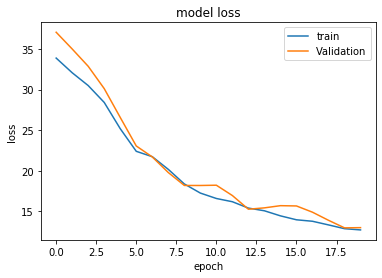

In [50]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper right')
plt.show()

In [51]:
# create the input set of data from whole dataset for prediction the next output set
x_input = dataset[-n_steps_in_all:,:]
x_input = x_input.reshape((1, n_steps_in_all, n_features_all))
x_input.shape

(1, 5, 3)

In [52]:
#predict the output set
pred_data = model2.predict(x_input, verbose=0)
pred_data = np.squeeze(pred_data, axis=0)
print(pred_data)

[[38.174236  8.296687 27.289248]
 [53.2079    7.575828 34.69987 ]
 [59.39005   3.774775 37.540867]
 [70.901794  1.459022 42.645992]]


Write the predicted values to the output files



In [0]:
#generate value for index column
index_no =[]
for i in range(0, len(pred_data)):
    index_no.append(len(dataset)+i+1)

#write the values to "output.csv" file
np.savetxt("output.csv", pred_data, delimiter=",",fmt='%1.3f')

#add column names and index values
df = pd.read_csv('output.csv', header=None)
df.rename(columns={0: 'Val_1', 1: 'Val_2', 2: 'Val_3'}, inplace=True)
df.insert(0,"Index",index_no,True)
df.to_csv('output.csv', index=False)


In [0]:
text = open("output.csv", "r")
text = ''.join([i for i in text]) \
    .replace(",", ";")\
    .replace(".",",")
x = open("FormatedOutput.csv","w")
x.writelines(text)
x.close()

In [55]:
!nvidia-smi

Sun Dec  1 23:33:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  